# Lesson 10 - Sentiment Analysis

This assignment requires that you build a sentiment analysis classifier for a series of tweets.
The data consists of a file "twitter_data.csv". The file contains 16,000 tweets with their respective score. The attributes are the sentences, and the score is either 4 (for positive) or 0 (for negative).

Assignment Instructions
1. Complete all questions below.
2. Comment on the applicability of the model on future tweets.  

In [85]:
# Import necessary libraries
import csv
import lda
import editdistance
import string
import re
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Specialty libraries
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from scipy.sparse import coo_matrix
from collections import Counter
import argparse
import pprint
import gensim
from wordcloud import WordCloud, STOPWORDS 
from nltk.stem.wordnet import WordNetLemmatizer

In [86]:
#Read files
url = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/twitter_data.csv"
df = pd.read_csv(url, sep=",")
df.columns = ['sentiment_label','tweet_text']
    
print(df.head())


   sentiment_label                                         tweet_text
0                4  @elephantbird Hey dear, Happy Friday to You  A...
1                4  Ughhh layin downnnn    Waiting for zeina to co...
2                0  @greeniebach I reckon he'll play, even if he's...
3                0              @vaLewee I know!  Saw it on the news!
4                0  very sad that http://www.fabchannel.com/ has c...


In [87]:
# But sentiment is either '4' or '0'. We'll change that to '1' or '0' to indicate positive or negative sentiment
df.sentiment_label=df.sentiment_label.replace(4,1)

In [88]:
#function for cleaning the tweets
def preprocess(text, list_of_steps):
    
    for step in list_of_steps:
        if step == 'remove_non_ascii':
            text = ''.join([x for x in text if ord(x) < 128])
        elif step == 'lowercase':
            text = text.lower()
        elif step == 'remove_punctuation':
            punct_exclude = set(string.punctuation)
            text = ''.join(char for char in text if char not in punct_exclude)
        elif step == 'remove_numbers':
            text = re.sub("\d+", "", text)
        elif step == 'strip_whitespace':
            text = ' '.join(text.split())
        elif step == 'remove_stopwords':
            stops = stopwords.words('english')
            word_list = text.split(' ')
            text_words = [word for word in word_list if word not in stops]
            text = ' '.join(text_words)
        elif step == 'stem_words':
            lmtzr = WordNetLemmatizer()
            word_list = text.split(' ')
            stemmed_words = [lmtzr.lemmatize(word) for word in word_list]
            text = ' '.join(stemmed_words)
    return text

In [89]:
# Clean positive tweets
steps = ['lowercase', 'remove_punctuation', 'remove_numbers', 'strip_whitespace']

df['clean_tweet'] = df['tweet_text'].map(lambda s: preprocess(s, steps))

In [90]:
#creating separate dfs for positive/negative sentiment labels
positive = df.loc[df['sentiment_label'] == 1]
negative = df.loc[df['sentiment_label'] == 0]

Q1: Generate word cloud for positive sentiment.

In [91]:
positive_text = " ".join(review for review in positive.clean_tweet)
print ("There are {} words in the combination of all review.".format(len(positive_text)))

There are 5492511 words in the combination of all review.


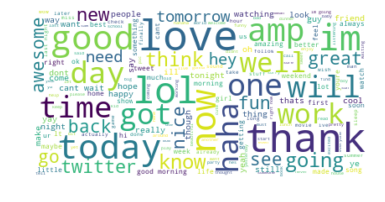

In [92]:
stopwords = set(STOPWORDS)
stopwords.update(["a", "the", "you", "I", "on"])

wordcloud = WordCloud(stopwords = stopwords, background_color = 'white', max_font_size = 50).generate(positive_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Q2: Generate word cloud for negative sentiment.

In [93]:
negative_text = " ".join(review for review in negative.clean_tweet)
print ("There are {} words in the combination of all review.".format(len(negative_text)))

There are 5570429 words in the combination of all review.


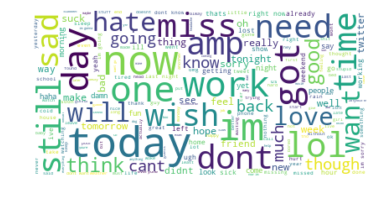

In [94]:
stopwords = set(STOPWORDS)
stopwords.update(["a", "the", "you", "I", "on"])

wordcloud = WordCloud(stopwords = stopwords, background_color = 'white', max_font_size = 50).generate(negative_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Q3: Split data into 70% for training and 30% for testing.

In [95]:
df.shape
#70% is 112000 -- training
#30% is 48000  -- testing

(160000, 3)

In [96]:
# Declare the TFIDF vectorizer.
vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, max_features=6228, stop_words='english')

# Fit the vectorizer over the dataset
clean_texts = df['clean_tweet']
tf_idf_tweets = vectorizer.fit_transform(clean_texts)

tweet_data = df.values.tolist()

In [97]:
# Generate 48,000 random row indices
print('Splitting into train-test. Please wait!')
from sklearn.model_selection import train_test_split

y_targets = np.array([y[0] for y in tweet_data])

X_train, X_test, y_train, y_test = train_test_split(tf_idf_tweets,
                                                    y_targets,
                                                    test_size=48000)
print('Done!')

Splitting into train-test. Please wait!
Done!


Q4: Build a classifier that classifies the sentiment of a sentence.

In [99]:
print('Starting a standard Logistic Model training!')
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
print('Done.')
lr

Starting a standard Logistic Model training!
Done.


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Q5: What is the accuracy of your model when applied to testing data?

In [100]:
## Compute results on the train and test set
train_probs = lr.predict_proba(X_train)
train_results = np.argmax(train_probs, axis=1)

test_probs = lr.predict_proba(X_test)
test_results = np.argmax(test_probs, axis=1)

In [101]:
# Compute accuracies
train_logical_correct = [pred == actual for pred, actual in zip(train_results, y_train)]
train_acc = np.mean(train_logical_correct)

test_logical_correct = [pred == actual for pred, actual in zip(test_results, y_test)]
test_acc = np.mean(test_logical_correct)

print('Train accuracy: {}'.format(train_acc))
print('Test accuracy: {}'.format(test_acc))

Train accuracy: 0.7823392857142857
Test accuracy: 0.755875


In [102]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

# Remember:
# Precision is the proportion of correct predictions among all predicted
# Recall (sensitivity) is the proportion of correct predictions among all true actual examples
# F1 is the harmonic average of precision and recall
# Support is count of actual cases of specific class
# Here, each of the following is a pair of numbers, the first is for class 1 ('1') and second for class 0 ('0')
precision, recall, f1, support = precision_recall_fscore_support(y_test, test_results)

# Get the parts of the confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, test_results).ravel()

# Print results
print(confusion_matrix(y_test, test_results))
print('='*35)
print('             Class 1   -   Class 0')
print('Precision: {}'.format(precision))
print('Recall   : {}'.format(recall))
print('F1       : {}'.format(f1))
print('Support  : {}'.format(support))

[[17550  6486]
 [ 5232 18732]]
             Class 1   -   Class 0
Precision: [0.77034501 0.74280276]
Recall   : [0.73015477 0.78167251]
F1       : [0.74971165 0.7617421 ]
Support  : [24036 23964]


Q6: What conclusions can you draw from the model?

From the model above, it looks a bit overfit because the training accuracy is greater than the testing accuracy. Even so, the precision is still very high so the model is not useless. If it were used, we would have to keep in mind the overfitting.

Q7: Is it better to have a model per source?

I think for our model, since it is overfitted from the source data, it might be better to have a different model if we were applying a different source of data. If we were to create a model that was less fitted to the data, perhaps the source data doesn't matter.